# Raytracing

In this fourth lab of the ErSE 210 - Seismology course, we will learn how to code a simple 2d *Raytracer*.

Let's start by recalling that raytracing can be accomplished by solving the following ODE system:    
$$
\begin{cases}
    \frac{d\overrightarrow{x}}{dl} = \frac{\overrightarrow{p}}{s(\overrightarrow{x})}\\
    \frac{d\overrightarrow{p}}{dl} = \nabla s(\overrightarrow{x})\\
    \frac{dT}{dl} = s(\overrightarrow{x})
\end{cases}   \qquad \overrightarrow{x}(l=0)=\overrightarrow{x_0}, \overrightarrow{p}(l=0)=\overrightarrow{p_0}
$$

where $\overrightarrow{x}=(x,z)$ is the position vector, $\overrightarrow{p}=(p_x,p_z)$ is the rayparameter vector, $s$ is the slowness, $l$ is the lenght of the ray, and $T$ is the traveltime.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from math import sin, cos
from scipy.ndimage import uniform_filter
from scipy.io import loadmat
from scipy.integrate import solve_ivp

## ODE in Python

In order to solve the raytracing problem we need to first familiarize with how ODEs are solved in Python. 

Whilst we will see that this can be very easily done using scipy and more specifically the `scipy.integrate.solve_ivp` routine, at first sight it may not be obvious how to use this routine. We will therefore start from a basic example of the form:

$$
\frac{dy}{dt}=f(y, t)
$$
where $y$ is the dependent variable we want to solve for, $t$ is the independent variable we need to march with, and $f(t, y)$ is a function of possibly both the dependent and indipendent variables which we need to provide to `solve_ivp`. Finally we also need to define the initial condition $y(t=0)=y0$.

Let's go through a very simple ODE: 

$$
\frac{dy}{dt}= - y / \tau
$$

which we know has exact solution: $y(t) = y0 * e^{-\frac{t}{\tau}}$.

In order to use the routine `solve_ivp` to solve this ODE numerically we need to follow a simple recipe:

- define the function $f(y,t)$
- set the desired time axis $t$
- set the initial condition $y0$
- call solve_ivp as y = solve_ivp(f, t, y0)

In [2]:
def rhsf(t, y, τ):
    """Function f=-y/tau
    """
    return -y/τ

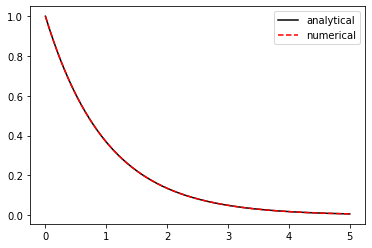

In [3]:
# ODE numerical solution
t = np.linspace(0, 5, 1000)
y0 = 1
τ = 1
sol = solve_ivp(rhsf, [t[0], t[-1]], [y0, ], t_eval=t, args=(τ,))
y = sol['y'].ravel()

# ODE analytical solution
yana = y0 * np.exp(-t/τ)

plt.figure()
plt.plot(t, yana, 'k', label='analytical')
plt.plot(t, y, '--r', label='numerical')
plt.legend();

Not surprising, the `solve_ivp` solver can succesfully provide a numerical estimate to our ODE that is very close to the analytical solution. 

Finally, we can also use so-called `events` to suddently stop the ODE from progressing over the pre-defined time axis. In this case for example, we will stop as soon as y decays to 0.4. Note that we need to write our condition such that what is returned by the event function is zero when we want to stop our ODE from progressing.

In [4]:
def event(t, y, τ): 
    return y[0]-0.4
event.terminal = True # set to True to trigger termination as soon as the condition is met
event.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event

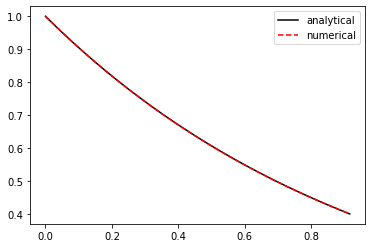

In [5]:
# ODE numerical solution
t = np.linspace(0, 5, 1000)
y0 = 1
τ = 1
sol = solve_ivp(rhsf, [t[0], t[-1]], [y0, ], t_eval=t, args=(τ,), events=event)
#print(sol)
t, y = sol['t'].ravel(), sol['y'].ravel()

# ODE analytical solution
yana = y0 * np.exp(-t/τ)

plt.figure()
plt.plot(t, yana, 'k', label='analytical')
plt.plot(t, y, '--r', label='numerical')
plt.legend();

We are now equipped with all the tools to implement a simple 2D raytracer.

## Raytracing

Let's now approach the raytracing ODE in the same way as we did for the simple example above. First of all we create a function which is able to define the RHS of our ODE

In [6]:
def rhsf(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    """RHS of raytracing ODE 
    
    Parameters
    ----------
    l : indipendent variable l
    r : dependent variable containing (x, z, px, pz, t)
    slowness : slowness 2d model
    dsdx : horizontal derivative of slowness 2d model
    dsdz : vertical derivative of slowness 2d model
    xaxis : horizontal axis
    zaxis : vertical axis
    dx : horizontal spacing
    dz : vertical spacing

    Returns
    -------
    drdt : RHS evaluation
    
    """
    m, n = slowness.shape
    # extract the different terms of the solution
    x = r[0]
    z = r[1]
    px = r[2]
    pz = r[3]
    drdt = np.zeros(len(r))

    # identify current position of the ray in the model
    xx = (x - xaxis[0]) // dx
    zz = (z - zaxis[0]) // dz
    xx = min([xx, n-1])
    xx = max([xx, 1])
    zz = min([zz, m-1])
    zz = max([zz, 1]) 

    # extract s, ds/dx, ds/dz at current position (nearest-neighbour interpolation)
    s = slowness[round(zz), round(xx)]
    dsdx = dsdx[round(zz), round(xx)]
    dsdz = dsdz[round(zz), round(xx)]
    
    # evaluate RHS
    drdt[0] = px/s
    drdt[1] = pz/s
    drdt[2] = dsdx
    drdt[3] = dsdz
    drdt[4] = s
    return drdt

In [7]:
def event_left(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return r[0]-xaxis[0]
def event_right(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return xaxis[-1]-r[0]
def event_top(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return r[1]-zaxis[0]
def event_bottom(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return zaxis[-1]-r[1]

event_left.terminal = True # set to True to trigger termination as soon as the condition is met
event_left.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event
event_right.terminal = True # set to True to trigger termination as soon as the condition is met
event_right.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event
event_top.terminal = True # set to True to trigger termination as soon as the condition is met
event_top.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event
event_bottom.terminal = True # set to True to trigger termination as soon as the condition is met
event_bottom.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event

In [8]:
def raytrace(vel, xaxis, zaxis, dx, dz, lstep, source, thetas):
    """Raytracing for multiple rays defined by the initial conditions (source, thetas)
    
    Parameters
    ----------
    vel : np.ndarray
        2D Velocity model (nz x nx)
    xaxis : np.ndarray
        Horizonal axis 
    zaxis : np.ndarray
        Vertical axis 
    dx : float
        Horizonal spacing 
    dz : float
        Vertical spacing 
    lstep : np.ndarray
        Ray lenght axis
    source : tuple
        Source location
    thetas : tuple
        Take-off angles
    
    """
    # Slowness and its spatial derivatives
    slowness = 1./vel
    [dsdz, dsdx] = np.gradient(slowness, dz, dx)

    for theta in thetas:
        # Initial condition
        r0=[source[0], source[1], 
            sin(theta * np.pi / 180) / vel[izs, ixs],
            cos(theta * np.pi / 180) / vel[izs, ixs], 0]

        # Solve ODE
        sol = solve_ivp(rhsf, [lstep[0], lstep[-1]], r0, t_eval=lstep, 
                        args=(slowness, dsdx, dsdz, xaxis, zaxis, dx, dz), events=[event_right, event_left,
                                                                           event_top, event_bottom])
        r = sol['y'].T
        
        # Display ray making sure we only plot the part of the ray that is inside the model
        zeros  = np.where(r[1:, 1] <= 0)[0]
        maxs = np.where(r[:, 1] >= max(z))[0]
        plt.plot(r[:,0]/1000, r[:,1]/1000, '#3FB97E')
    plt.axis('tight')
    #plt.xlim(x[0]/1000, x[-1]/1000)
    #plt.ylim(z[-1]/1000, z[0]/1000);

### Vertical gradient

We can now try to raytrace in a simple model that contains a vertical gradient. We start by defining the velocity model and computing its spatial derivatives required to evaluate the RHS of our ODE. We also decide the location of our source ($\overrightarrow{x_0}$) and the take-off angle which is directly related to the initial ray parameter ($\overrightarrow{p_0}$).

In [9]:
# Spatial axes
dx, dz = 100, 100
x = np.arange(0, 60000, dx)
z = np.arange(0, 30000, dz)

[zz, xx]= np.meshgrid(z, x, indexing='ij')

# Velocity model
vel = 1000 + 0.032 * zz

# Slowness and its spatial derivatives
slowness = 1./vel;
[dsdz, dsdx] = np.gradient(slowness, dz, dx)

# Source location
ixs = 0
izs = 0
source = [x[ixs], z[izs]] 

# Take off angles
thetas = np.arange(5, 80, 5)

We can now raytrace

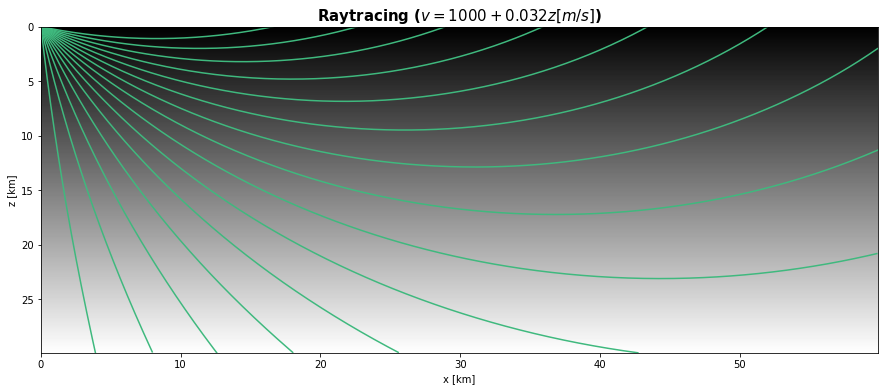

In [10]:
plt.figure(figsize=(15, 6))
plt.imshow(vel, extent=(x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000),  cmap='gray')
plt.xlabel('x [km]')
plt.ylabel('z [km]')
plt.title(r'Raytracing ($v=1000 + 0.032 z [m/s]$)', fontsize=15, fontweight='bold')

# Vector of lengths
lstep = np.linspace(0, 1e5, 1000)

# Raytrace
raytrace(vel, x, z, dx, dz, lstep, source, thetas)

### Marmousi

Finally we repeat the same exercise using the famous [Marmousi](https://wiki.seg.org/wiki/Dictionary:Marmousi_model) model

In [11]:
f = loadmat('../data/marmousi.mat')
x = np.squeeze(f['x'])
z = np.squeeze(f['z'])
vel = f['vel']

# Spatial axes
dx, dz = x[1]-x[0], z[1]-z[0]
[zz, xx] = np.meshgrid(z, x, indexing='ij')

# Smooth velocity model
vel = uniform_filter(vel, size=4)

# Slowness and its spatial derivatives
slowness = 1./vel;
[dsdz, dsdx] = np.gradient(slowness, dz, dx)

# Source location
ixs = 328
izs = 0
source = [x[ixs], z[izs]] 

# Take off angles
thetas=np.arange(-30, 30, 5)

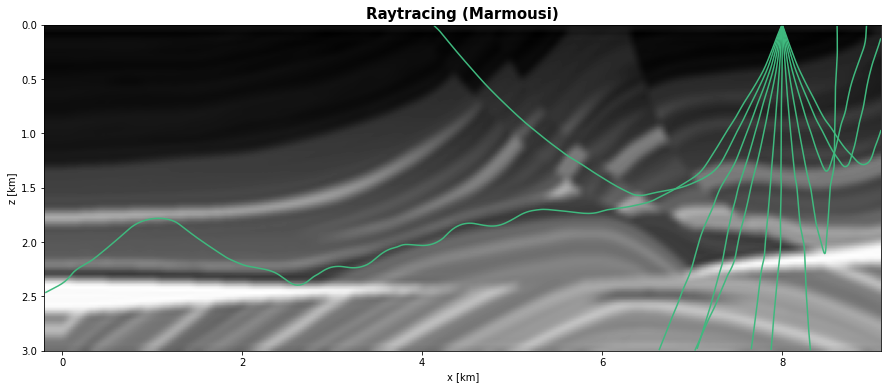

In [12]:
plt.figure(figsize=(15, 6))
plt.imshow(vel, extent=(x[0]/1000,x[-1]/1000,z[-1]/1000,z[0]/1000), 
           cmap='gray')
plt.xlabel('x [km]')
plt.ylabel('z [km]')
plt.title(r'Raytracing (Marmousi)', fontsize=15, fontweight='bold')

# Vector of lengths
lstep=np.arange(0, 10000, 25)

# Raytrace
raytrace(vel, x, z, dx, dz, lstep, source, thetas)

Time to play! Try to modify the position of your source and take-off angles. 

**Exercise 1**: try to reconstruct a traveltime map by gridding the traveltime of the available rays. Compare this result with that obtained using an eikonal solver such as [scikit-fmm](https://github.com/scikit-fmm/scikit-fmm).

**Exercise 2**: when we look at the previous example, most rays are coming back to the surface (this is always the case for velocity gradients!): try to extract the time at those locations and display the associated traveltime curve (as a bonus, you may want to compare it with the analytical espression that we have derived in class). Repeat the same also for the Marmousi model using multiple sources and create a source-receiver traveltime table with traveltimes of all those rays that come back. You will try to use this in one of our future labs to invert for the underlying velocity model.